In [1]:
!nvidia-smi

Tue Sep 13 10:41:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1) Installing libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [ ]:
# enter your personal read token

In [5]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [6]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/twitter_election_scrapped", use_auth_token=True)

print(aggression_dataset)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--twitter_election_scrapped-7ae30e4a8eb3e56b/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1599
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 200
    })
})


In [7]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 1599
})

## 3) Converting to dataframe

In [8]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,"""Asked if these files of historic value were s...",0
1,I have to say this. Without a civilian governm...,0
2,Ladies and Gentlemen This man wants to get awa...,2
3,Just curious - are the BJP leaders sitting on ...,1
4,US President Barack Obama congratulates @naren...,0


In [9]:
test_df = aggression_dataset['test'][:]

In [10]:
train_df['Label'].value_counts()

0    794
1    414
2    391
Name: Label, dtype: int64

In [ ]:
# 1599
# NAG-CAG-OAG (0-1-2) = 0.50-0.26-0.24

Seeing Distribution

In [11]:
disb_df = train_df.copy(deep=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


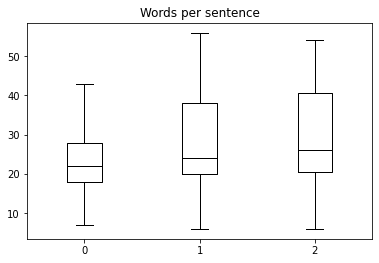

In [12]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [13]:
from transformers import AutoTokenizer

In [14]:
model_ckpt = 'l3cube-pune/hing-bert'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
tokenizer.vocab_size

30522

In [16]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [17]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [19]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [21]:
import torch

In [ ]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [22]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [24]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [25]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [26]:
from transformers import Trainer, TrainingArguments

In [27]:
# Defining hyperparameters
eval_batch_size = 8
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-ours-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2.824279936868144e-05,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  weight_decay=0.17327236865873835,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="hing-bert-ours-DS",
                                  push_to_hub=True)

In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [28]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.22, 0.27, 0.51]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [29]:
from transformers import EarlyStoppingCallback

In [30]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [31]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

https://huggingface.co/l3cube-pune/hing-bert/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpvycb2wwj


storing https://huggingface.co/l3cube-pune/hing-bert/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/d52c8be56cd7426f65f746f8597f9a2955921e2ad53793f8949bd8794e6372ef.ac4c51fbb6396469b4ec05f0bdf5f51204ca04692ad36e8ade986838956c1bd8
creating metadata file for /root/.cache/huggingface/transformers/d52c8be56cd7426f65f746f8597f9a2955921e2ad53793f8949bd8794e6372ef.ac4c51fbb6396469b4ec05f0bdf5f51204ca04692ad36e8ade986838956c1bd8
loading configuration file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d52c8be56cd7426f65f746f8597f9a2955921e2ad53793f8949bd8794e6372ef.ac4c51fbb6396469b4ec05f0bdf5f51204ca04692ad36e8ade986838956c1bd8
Model config BertConfig {
  "_name_or_path": "l3cube-pune/hing-bert",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "eos_token_ids": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu

storing https://huggingface.co/l3cube-pune/hing-bert/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/d118ddc529dbc880960f903c0d422897238ffe49ed8058246505dba7a5e39557.381c60fcfdae2869564856d4bf23b4a0fa537a1bf56e435e2d344f81dc77af20
creating metadata file for /root/.cache/huggingface/transformers/d118ddc529dbc880960f903c0d422897238ffe49ed8058246505dba7a5e39557.381c60fcfdae2869564856d4bf23b4a0fa537a1bf56e435e2d344f81dc77af20
loading weights file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/d118ddc529dbc880960f903c0d422897238ffe49ed8058246505dba7a5e39557.381c60fcfdae2869564856d4bf23b4a0fa537a1bf56e435e2d344f81dc77af20
Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.tra

wandb: Currently logged in as: sky-s-the-limit. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
199,0.885200,0.717100,0.675000,0.668276,0.625057,0.595462
398,0.583700,0.807374,0.670000,0.699431,0.619825,0.569132
597,0.302300,1.003684,0.730000,0.704753,0.699990,0.696081
796,0.139700,1.244236,0.710000,0.677884,0.673957,0.672093
995,0.044900,1.562190,0.710000,0.684840,0.672387,0.665779


***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Saving model checkpoint to l3cube-pune/hing-bert-finetuned-ours-DS/checkpoint-199
Configuration saved in l3cube-pune/hing-bert-finetuned-ours-DS/checkpoint-199/config.json
Model weights saved in l3cube-pune/hing-bert-finetuned-ours-DS/checkpoint-199/pytorch_model.bin
tokenizer config file saved in l3cube-pune/hing-bert-finetuned-ours-DS/checkpoint-199/tokenizer_config.json
Special tokens file saved in l3cube-pune/hing-bert-finetuned-ours-DS/checkpoint-199/special_tokens_map.json
tokenizer config file saved in l3cube-pune/hing-bert-finetuned-ours-DS/tokenizer_config.json
Special tokens file saved in l3cube-pune/hing-bert-finetuned-ours-DS/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Saving model checkpoint to l3cube-pune/hing-bert-finetuned-ours-DS/checkpoint-398
Configuration saved in l3cube-pune/hing-bert-finetuned-ours-DS/checkpoint-398/config.json
Model weights saved 

eval/accuracy,▂▁█▆▆
eval/f1,▂▁█▇▆
eval/loss,▁▂▃▅█
eval/precision,▁▇█▃▄
eval/recall,▁▁█▆▆
eval/runtime,▁█▅▆▅
eval/samples_per_second,█▁▄▃▄
eval/steps_per_second,█▁▄▃▄
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/learning_rate,█▆▄▃▁


In [32]:
trainer.push_to_hub()

Saving model checkpoint to l3cube-pune/hing-bert-finetuned-ours-DS
Configuration saved in l3cube-pune/hing-bert-finetuned-ours-DS/config.json
Model weights saved in l3cube-pune/hing-bert-finetuned-ours-DS/pytorch_model.bin
tokenizer config file saved in l3cube-pune/hing-bert-finetuned-ours-DS/tokenizer_config.json
Special tokens file saved in l3cube-pune/hing-bert-finetuned-ours-DS/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/418M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/SkyR/hing-bert-finetuned-ours-DS
   7fe3b72..1190b8c  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/SkyR/hing-bert-finetuned-ours-DS
   7fe3b72..1190b8c  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.71}, {'name': 'Precision', 'type': 'precision', 'value': 0.6848402110550448}, {'name': 'Recall', 'type': 'recall', 'value': 0.672387136672851}, {'name': 'F1', 'type': 'f1', 'value': 0.6657785467474485}]}
To https://huggingface.co/SkyR/hing-bert-finetuned-ours-DS
   1190b8c..5bf6585  main -> main

   1190b8c..5bf6585  main -> main



'https://huggingface.co/SkyR/hing-bert-finetuned-ours-DS/commit/1190b8c4c8164c5dad919b3b4a55d08a0026b417'

## 8) Predictions and Results

In [33]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [34]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [35]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [36]:
preds_output_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 200
  Batch size = 8


In [37]:
preds_output_test.metrics

{'test_loss': 1.3502168655395508,
 'test_accuracy': 0.665,
 'test_precision': 0.6370987531359252,
 'test_recall': 0.6162646876932593,
 'test_f1': 0.6227166053045193,
 'test_runtime': 1.2619,
 'test_samples_per_second': 158.486,
 'test_steps_per_second': 19.811}

In [38]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [39]:
y_valid_test = np.array(test_dataset.labels)

In [40]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [41]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.79      0.82      0.80        99
         CAG       0.44      0.50      0.47        52
         OAG       0.68      0.53      0.60        49

    accuracy                           0.67       200
   macro avg       0.64      0.62      0.62       200
weighted avg       0.67      0.67      0.67       200



In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

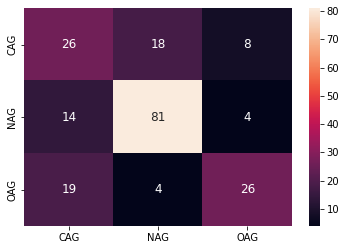

In [43]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 